#**<center>GPU Programmation - ENSAE</center>**

 **<center>Yannick Ly, Melchior Prugniaud</center>** 

#**GAN applying to barrier call option**




In this notebook we tried to implement the GAN architecture to generate prices of barrier call option using as input the option price distribution generated by a nested monte carlo simulation (with Euler for local volatality).

Parameters used to generate the prices of barrier call option :  
- Strike K = 100
- T = 1
- S0 = 100
- B = 120

## Setup

In [1]:
##############################
#  SETUP PYTHON ENVIRONMENT  #  
##############################

!pip install torch torchvision

In [2]:
!git clone https://github.com/pihk94/ProgGPU

fatal: destination path 'ProgGPU' already exists and is not an empty directory.


In [0]:
import warnings
warnings.filterwarnings("ignore")

## Helper functions


In [0]:
import numpy as np
import pandas as pd

def to_csv(mat, epoch):
  x = mat[1][0].cpu().detach().numpy()
  x = pd.DataFrame(x)
  x.to_csv("generation/%d.csv" % epoch)

## Architectures

In [0]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, opt):
        super(Generator, self).__init__()

        self.matrix_shape = (1, opt.matrix_height, opt.matrix_width)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(self.matrix_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        mat = self.model(z)
        mat = mat.view(mat.size(0), *self.matrix_shape)
        return mat

class Discriminator(nn.Module):
    def __init__(self, opt):
        super(Discriminator, self).__init__()

        self.matrix_shape = (1, opt.matrix_height, opt.matrix_width)

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.matrix_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, mat):
        mat_flat = mat.view(mat.size(0), -1)
        validity = self.model(mat_flat)
        return validity

## GAN

In [5]:
import argparse
import os
import glob
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

##############################
#    MODEL CONFIGURATION     # 
##############################

parser = argparse.ArgumentParser()
# dataset parameters
parser.add_argument("--matrix_height", type=int, default=1024, help="size of matrix height")
parser.add_argument("--matrix_width", type=int, default=100, help="size of matrix width")
# training parameters
parser.add_argument("--cuda", type=bool, default=False, help="change to GPU mode")
parser.add_argument("--n_epochs", type=int, default=500, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=2, help="size of the batches")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
# GAN parameters
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
opt = parser.parse_args("")

# GPU option
cuda = torch.cuda.is_available()
if cuda:
    print('Models moved to GPU.')
    opt.cuda = True

# Create generation directory
os.makedirs("generation", exist_ok=True)

# Configure data loader
path = glob.glob("ProgGPU/Data/data*.csv")
full_data = np.empty((len(path), 1, 32*32, 100))
for file, i in zip(path, range(len(path))):
  tmp = np.array(pd.read_csv(file).T.loc["Prix"].to_list()).reshape((1, 32*32, 100))
  full_data[i] = tmp

dataloader = DataLoader(torch.Tensor(full_data), batch_size = opt.batch_size, shuffle = True, num_workers = opt.n_cpu)

def training_loop(dataloader, opt):

  # Initialize generator and discriminator
  G = Generator(opt)
  D = Discriminator(opt)

  # Loss function
  adversarial_loss = torch.nn.BCELoss()

  # Optimizers
  optimizer_G = torch.optim.Adam(G.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
  optimizer_D = torch.optim.Adam(D.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2)) 

  # to GPU
  Tensor = torch.FloatTensor
  if opt.cuda:
      G.cuda()
      D.cuda()
      adversarial_loss.cuda()
      Tensor = torch.cuda.FloatTensor

  # Training loop
  for epoch in range(opt.n_epochs):
      for i, batch in enumerate(dataloader):

          # Adversarial ground truths
          valid = Variable(Tensor(batch.size(0), 1).fill_(1.0), requires_grad=False)
          fake = Variable(Tensor(batch.size(0), 1).fill_(0.0), requires_grad=False)

          # Configure input
          real_prices = Variable(batch.type(Tensor))

          # -----------------
          #  Train Generator
          # -----------------

          optimizer_G.zero_grad()

          # Sample noise as generator input
          z = Variable(Tensor(np.random.normal(0, 1, (batch.shape[0], opt.latent_dim))))

          # Generate a batch of images
          gen_prices = G(z)

          # Loss measures generator's ability to fool the discriminator
          g_loss = adversarial_loss(D(gen_prices), valid)

          g_loss.backward()
          optimizer_G.step()

          # ---------------------
          #  Train Discriminator
          # ---------------------

          optimizer_D.zero_grad()

          # Measure discriminator's ability to classify real from generated samples
          real_loss = adversarial_loss(D(real_prices), valid)
          fake_loss = adversarial_loss(D(gen_prices.detach()), fake)
          d_loss = (real_loss + fake_loss) / 2

          d_loss.backward()
          optimizer_D.step()

          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
          )
      to_csv(gen_prices, epoch)

Models moved to GPU.


In [0]:
  G = Generator(opt)
  D = Discriminator(opt)

In [39]:
G

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=102400, bias=True)
    (12): Tanh()
  )
)

In [40]:
D

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=102400, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [6]:
training_loop(dataloader, opt)

[Epoch 0/500] [Batch 0/6] [D loss: 0.607661] [G loss: 0.724956]
[Epoch 0/500] [Batch 1/6] [D loss: 0.251978] [G loss: 0.926683]
[Epoch 0/500] [Batch 2/6] [D loss: 0.186047] [G loss: 1.168905]
[Epoch 0/500] [Batch 3/6] [D loss: 0.141160] [G loss: 1.402564]
[Epoch 0/500] [Batch 4/6] [D loss: 0.114035] [G loss: 1.590056]
[Epoch 0/500] [Batch 5/6] [D loss: 0.109899] [G loss: 1.625278]
[Epoch 1/500] [Batch 0/6] [D loss: 0.107586] [G loss: 1.642102]
[Epoch 1/500] [Batch 1/6] [D loss: 0.109872] [G loss: 1.623303]
[Epoch 1/500] [Batch 2/6] [D loss: 0.204881] [G loss: 1.097390]
[Epoch 1/500] [Batch 3/6] [D loss: 0.157661] [G loss: 1.328990]
[Epoch 1/500] [Batch 4/6] [D loss: 0.319304] [G loss: 0.760178]
[Epoch 1/500] [Batch 5/6] [D loss: 0.293386] [G loss: 0.819639]
[Epoch 2/500] [Batch 0/6] [D loss: 0.263477] [G loss: 0.901913]
[Epoch 2/500] [Batch 1/6] [D loss: 0.267305] [G loss: 0.882508]
[Epoch 2/500] [Batch 2/6] [D loss: 0.133744] [G loss: 1.449727]
[Epoch 2/500] [Batch 3/6] [D loss: 19.86

In [20]:
import matplotlib.pyplot as plt

TRUE_prices = pd.DataFrame(full_data[0][0].T)
TRUE_prices.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.742453,1.254549,0.204962,0.433721,0.128706,2.576922,20.578537,39.367072,0.992204,0.270390,2.840758,1.040913,0.196649,1.653906,1.742205,0.158762,3.920613,0.431959,0.681649,0.203033,0.113028,2.174778,2.293153,0.711523,0.253384,0.536163,0.198839,0.335105,0.162067,0.206975,0.167357,0.912711,1.317581,1.388219,0.339669,0.203093,0.090569,0.418769,0.048263,0.552232,...,0.226095,0.277332,1.239072,1.029882,1.260000,0.748010,0.246205,0.289215,0.660638,0.118001,0.708659,1.128454,0.336351,0.760228,0.315094,2.018874,5.377488,0.682987,0.585950,0.389348,0.155309,0.182631,0.632876,29.960661,0.484321,23.000926,0.680579,0.589985,2.149026,2.085796,0.167198,0.259895,2.994599,0.572626,0.165504,0.353921,0.231187,35.485187,0.377885,0.225831
std,4.823753,1.993139,0.445634,0.732778,0.489691,2.984583,13.129895,12.491434,1.290256,0.671992,3.440797,1.410403,0.505869,2.116857,2.677097,0.362571,5.263552,0.996831,1.144881,0.538110,0.231024,2.798176,3.021695,1.214932,0.613795,1.308618,0.482229,0.555196,0.591042,0.493181,0.441097,1.480256,1.989329,2.049042,0.657321,0.513000,0.273671,0.671701,0.142547,0.777905,...,0.645879,0.809749,1.936196,1.702023,1.844397,1.047554,0.712020,0.588892,1.205112,0.468062,0.951176,1.648697,0.676023,1.184254,0.533454,2.799370,7.510415,1.550641,1.298761,0.937157,0.291993,0.434851,1.290093,15.757630,0.997870,9.042776,1.047090,1.192072,3.459225,3.058559,0.372744,0.691911,4.550608,0.934592,0.537861,0.623531,0.522624,13.892602,0.618751,0.620114
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.305496,3.544572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.515545,0.000000,3.480461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.874815,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.030914,36.284067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.730703,0.000000,17.158402,0.000000,0.0

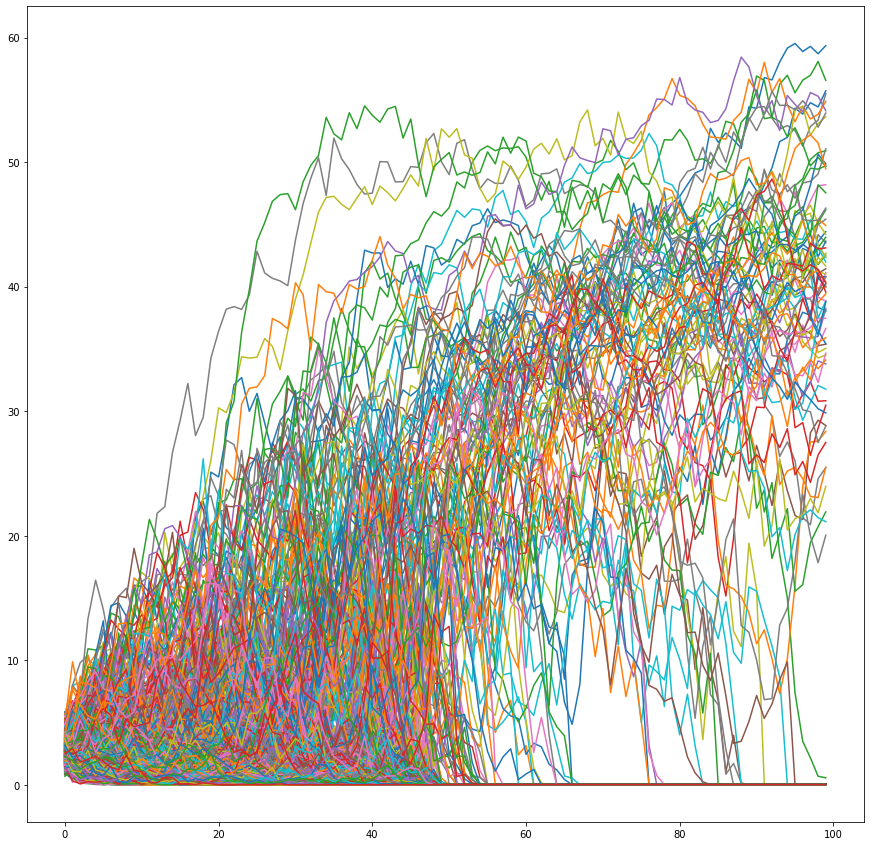

In [30]:
plt.figure(figsize=(15,15))
plt.plot(TRUE_prices)
plt.show()

In [32]:
type(TRUE_prices.columns)

pandas.core.indexes.range.RangeIndex

In [25]:
GEN_prices = pd.read_csv('generation/499.csv')
GEN_prices = GEN_prices[GEN_prices.columns[1:]].T
GEN_prices.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.001321,-0.002028,0.000744,0.002002,0.002986,-0.000670,-0.004033,-0.003051,-0.000751,0.001289,0.001453,0.000067,-0.001913,-0.002611,-0.002818,-0.000559,0.001163,0.000542,-0.000872,-0.001952,0.001963,0.001577,-0.001629,0.000470,-0.001834,0.000709,-0.001695,0.001665,0.002997,0.000444,0.000812,-0.000887,0.000953,-0.002832,-0.003448,-0.003316,0.001578,0.000246,0.001044,-0.000209,...,0.001174,-0.001534,0.000054,0.003679,-0.001229,0.000757,0.001901,0.001803,-0.001111,0.001351,0.002972,0.001246,0.000170,-0.000737,0.001403,-0.001914,0.000491,-0.000730,-0.000508,0.000529,0.000708,-0.000801,0.002762,-0.005930,-0.001822,-0.003498,-0.002181,0.001227,0.000890,0.002147,0.000784,0.002878,0.000876,-0.002401,-0.001563,0.001043,0.001184,-0.003350,0.000656,0.000287
std,0.017296,0.016387,0.015610,0.016267,0.016838,0.020565,0.019441,0.021261,0.018818,0.013282,0.016181,0.016660,0.017959,0.018502,0.018295,0.016546,0.016571,0.015138,0.016355,0.015455,0.015622,0.016908,0.020095,0.018216,0.013938,0.015653,0.014341,0.016337,0.015502,0.013695,0.014656,0.014897,0.019327,0.019494,0.016400,0.018834,0.014639,0.016315,0.017004,0.020402,...,0.014877,0.015147,0.016217,0.015615,0.016414,0.019046,0.015937,0.015532,0.015070,0.014794,0.018458,0.017730,0.017692,0.018551,0.014915,0.020007,0.016955,0.015327,0.014008,0.016970,0.015457,0.016046,0.017251,0.018680,0.016695,0.023244,0.020020,0.016042,0.018066,0.017398,0.016185,0.014575,0.019622,0.016254,0.016770,0.014851,0.016868,0.019691,0.016162,0.014176
min,-0.047184,-0.047032,-0.040872,-0.045808,-0.048370,-0.053563,-0.045309,-0.047828,-0.046828,-0.039766,-0.040345,-0.037957,-0.047812,-0.052539,-0.059968,-0.050137,-0.035670,-0.046993,-0.047301,-0.045462,-0.040244,-0.048496,-0.053700,-0.054927,-0.056702,-0.048902,-0.037432,-0.036553,-0.032935,-0.043167,-0.030226,-0.047985,-0.037511,-0.055778,-0.054280,-0.046345,-0.038104,-0.037166,-0.049244,-0.052050,...,-0.041811,-0.044401,-0.047062,-0.026520,-0.037069,-0.049987,-0.043330,-0.040965,-0.039628,-0.055941,-0.054583,-0.040307,-0.040546,-0.048608,-0.034980,-0.054803,-0.038157,-0.037247,-0.035440,-0.038322,-0.043959,-0.047964,-0.067777,-0.046520,-0.047382,-0.061687,-0.056380,-0.036017,-0.040725,-0.046341,-0.040392,-0.041897,-0.060790,-0.050561,-0.047898,-0.030778,-0.044528,-0.055243,-0.036507,-0.032663
25%,-0.010347,-0.010380,-0.009226,-0.007016,-0.009013,-0.012415,-0.019329,-0.020180,-0.010791,-0.005948,-0.007367,-0.010840,-0.012847,-0.012956,-0.012149,-0.011339,-0.008434,-0.008574,-0.010334,-0.010372,-0.005225,-0.009458,-0.015134,-0.009605,-0.010124,-0.007820,-0.011086,-0.008586,-0.007133,-0.008684,-0.008616,-0.009666,-0.013879,-0.012147,-0.012573,-0.014893,-0.006579,-0.010128,-0.006242,-0.012166,...,-0.007915,-0.011741,-0.008979,-0.007714,-0.010825,-0.010489,-0.006668,-0.005869,-0.009119,-0.006718,-0.

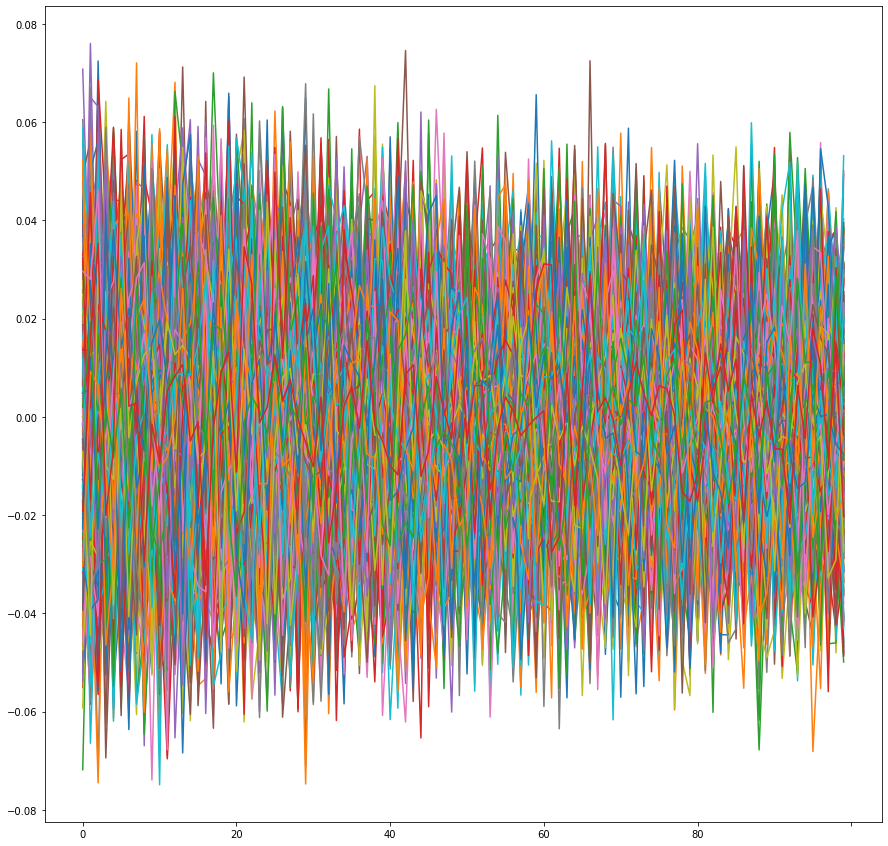

In [37]:
plt.figure(figsize=(15,15))
plt.plot(GEN_prices)
plt.xticks(np.arange(0, 101, 20))
plt.show()

As you can see the results are not very good, we have negative option prices over time.  
The training of the generator and the discriminator are not good enough because their architectures are to simple. Plus, we have only 12 matrix distributions as input whichi is not enought at all to train a GAN.

The main goal of our approach was to see if we can use GAN for another purpose than images.